In [1]:
!pip install -r requirements_ejercicio2.txt

In [24]:
!pip install apache-beam[gcp] google-cloud-storage

In [34]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling pack

In [3]:
import json
import pandas as pd
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

import utils  # archivo en ../src/utils.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Crear un bucket de almacenamiento en la nube

In [28]:
PROJECT_ID = 'deteccion-trolls'
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [5]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [6]:
BUCKET_NAME = 'cyber-trolls'
REGION = 'europe-west9'

In [7]:
!gsutil ls -al gs://$BUCKET_NAME

   1315564  2024-04-07T04:54:03Z  gs://cyber-trolls/balanced_dataset.json#1712465643072980  metageneration=1
   1857374  2024-04-07T19:15:33Z  gs://cyber-trolls/cleaned_data.json#1712517333059005  metageneration=1
TOTAL: 2 objects, 3172938 bytes (3.03 MiB)


In [8]:
print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")

Project: deteccion-trolls
Region: europe-west9
Bucket: cyber-trolls


## Crear una copia de seguridad

In [9]:
!gsutil cp gs://$BUCKET_NAME/cleaned_data.json gs://$BUCKET_NAME/backup_data.json

Copying gs://cyber-trolls/cleaned_data.json [Content-Type=application/json]...
- [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


## Crear el Pipeline de Preprocesamiento

In [14]:
# primero subir al sistemas de archivos de colab cleaned_data.json
!python preprocess.py --runner DirectRunner  # archivo en ../src/preprocess.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


El script anterior genera un archivo de salida con los datos preprocesados, en el sistema de archivo de Colab.

In [31]:
!ls

cleaned_data.json		       __pycache__		    setup.py
preprocessed_data-00000-of-00001.json  requirements_ejercicio2.txt  twitchstreaming.egg-info
preprocess.py			       sample_data		    utils.py


In [16]:
data_processed = []

with open("preprocessed_data-00000-of-00001.json", "r") as file:
    for line in file:
        data_processed.append(json.loads(line))

df = pd.DataFrame(data_processed)
print(df.head())

                                             content  label
0                              get fucking real dude      1
1  dirty come crook rengel dems fucking corrupt j...      1
2  fuck could day let hour ping later sched writi...      1
3  dude dont finish enclosing fucking shower hate...      1
4         wtf talking men men thats menage thats gay      1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20001 non-null  object
 1   label    20001 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [30]:
!python preprocess.py --runner DataflowRunner \
                      --project deteccion-trolls \
                      --temp_location gs://cyber-trolls \
                      --region europe-west9 \
                      --setup_file setup.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Traceback (most recent call last):
  File "/content/preprocess.py", line 83, in <module>
    run(
  File "/content/preprocess.py", line 51, in run
    with beam.Pipeline(options=options) as p:
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/pipeline.py", line 612, in __exit__
    self.result = self.run()
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/pipeline.py", line 562, in run
    self._options).run(False)
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/pipeline.py", line 586, in run
    return self.runner.run_pipeline(self, self._options)
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/runners/dataflow/dataflow_runner.py", line 393, in run_pipeline
    artifacts = environments.python_sdk_dependencies(op

## Análisis Exploratorio de los Datos Procesados

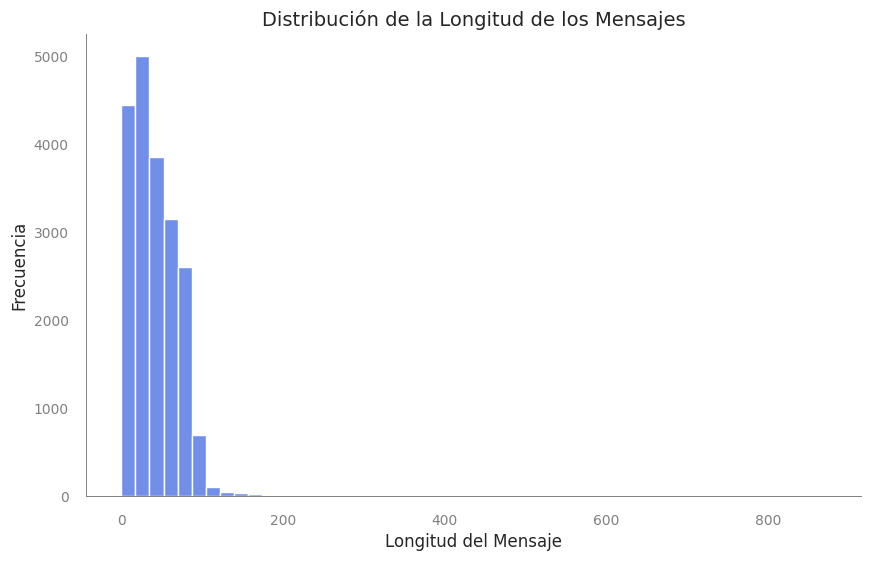

In [16]:
utils.plot_message_length(df,'content')

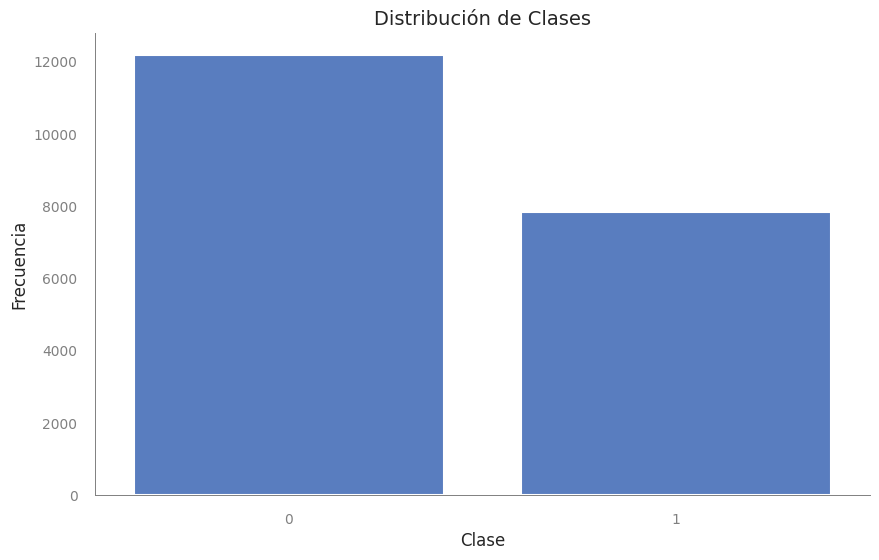

In [17]:
utils.plot_class_distribution(df, 'label')

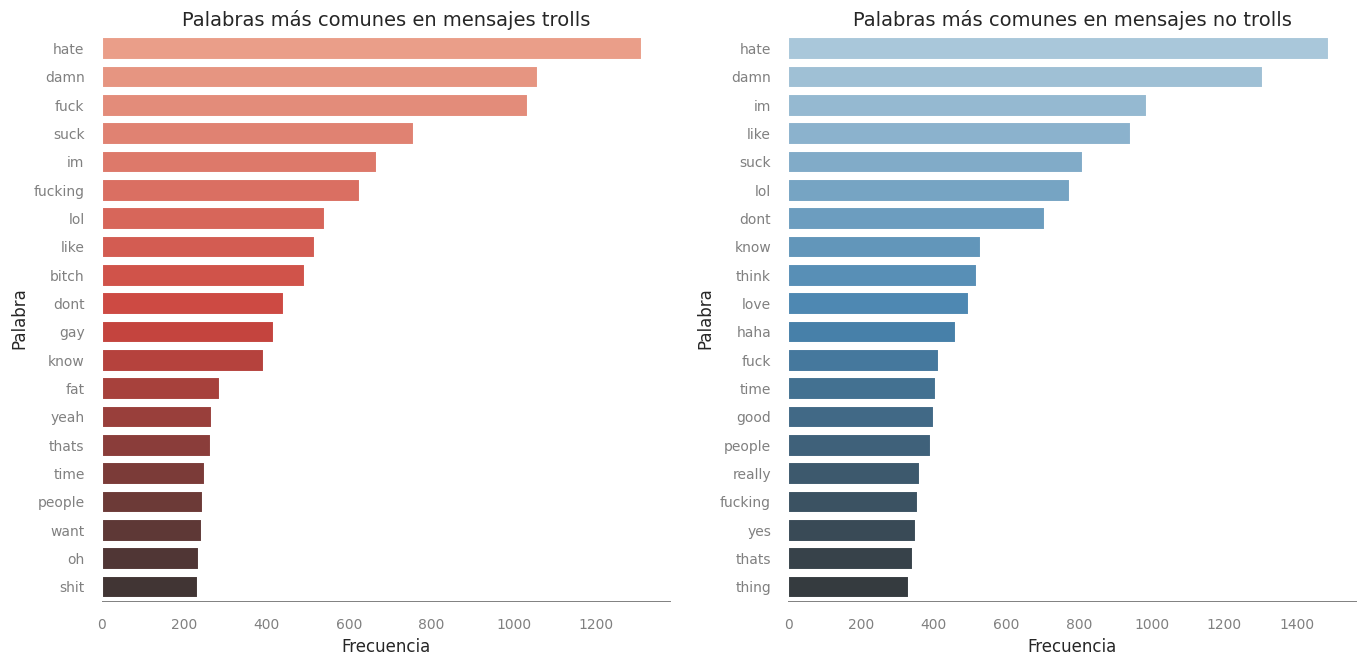

In [18]:
utils.plot_common_words_by_class(df)

In [19]:
texts = df['content'].tolist()
utils.vocabulary_diversity(texts)

Vocabulario total: 144424, Vocabulario único: 16684, Diversidad de vocabulario: 0.11552096604442474


## Balanceo de clases

Queremos crear un nuevo dataset con el mismo número de instancias para cada clase:

In [18]:
count_class_0, count_class_1 = df['label'].value_counts()

# Dividimos el DataFrame por clase
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

# Downsampling de la clase mayoritaria
df_class_0_under = df_class_0.sample(count_class_1)
df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)

# Verificamos el nuevo balanceo de clases
print(df_balanced['label'].value_counts())

0    7822
1    7822
Name: label, dtype: int64


In [22]:
# Guardamos los datos
df_balanced.to_json('balanced_dataset.json', orient='records', lines=True)

## Carga los Datos desde el bucket de GCP

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [45]:
FILE_PATH = 'gs://cyber-trolls/balanced_dataset.json'
data = pd.read_json(FILE_PATH, lines=True)

data = data[['content', 'label']] # columnas de interés

# Dividir los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

In [47]:
print(train.shape)
print(test.shape)

(12515, 2)
(3129, 2)


In [48]:
train.head()

,content,label
8005,joke mani wasnt taking piss anything,1
5180,big fat chocolate one interpret however like,0
2166,tell something snow,0
2691,oh wow haha read guygirls poem love name feel ...,0
11412,heyve proved fucking irrelevant making go read,1


In [49]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    train['content'],
    train['label'],
    test_size=0.2,
    random_state=42,
    stratify=train['label']
)

In [50]:
X_train.head()

1288                          many language fluently speak
7341     pig france executed public hanging murder chil...
11154    friend married gay burned badly dont want even...
4618         hmmpopcicles dont eat much really hot outside
4550                                            fascinates
Name: content, dtype: object

## Entrenamiento

In [38]:
!pip install pyngrok

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def train_and_tune(x_train, y_train, n_jobs=-1, cv=5, random_state=42):
    """
    Entrena y optimiza un modelo RandomForest utilizando GridSearchCV.

    Parámetros:
    - x_train: Características de entrenamiento.
    - y_train: Etiquetas de entrenamiento.
    - n_jobs: Número de trabajos para correr en paralelo.
    - cv: Número de pliegues de validación cruzada.
    - random_state: Semilla para la reproducibilidad de los resultados.

    Retorna:
    - El modelo entrenado con la mejor combinación de parámetros.
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier(random_state=random_state)),
    ])

    parameters = {
        'clf__n_estimators': [100, 200],
        'clf__min_samples_leaf': [1, 2],
        'clf__class_weight': [None, 'balanced']
    }

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=n_jobs, cv=cv)
    grid_search.fit(x_train, y_train)

    print("Mejores parámetros encontrados:")
    print(grid_search.best_params_)

    return grid_search.best_estimator_


def train_and_evaluate(x_train, y_train, x_val, y_val, min_samples_leaf=1, n_estimators=200, random_state=42):
    """
    Entrena un modelo RandomForest y lo evalúa en un conjunto de validación.

    Parámetros:
    - x_train, y_train: Datos de entrenamiento.
    - x_val, y_val: Datos de validación.
    - vectorizer_params: Parámetros para el TfidfVectorizer.
    - classifier_params: Parámetros para RandomForestClassifier.

    Retorna:
    - Un diccionario con el modelo y las métricas de evaluación.
    """
    if not isinstance(x_train, pd.Series) or not isinstance(x_val, pd.Series):
        raise ValueError("x_train y x_val deben ser Series de pandas.")

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            min_samples_leaf=min_samples_leaf,
            n_estimators=n_estimators,
            random_state=random_state))
    ])

    pipeline.fit(x_train, y_train)
    predictions = pipeline.predict(x_val)

    # Métricas de evaluación
    accuracy = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average='weighted')
    print(classification_report(y_val, predictions))

    # Matriz de confusión
    cm = confusion_matrix(y_val, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {'model': pipeline, 'accuracy': accuracy, 'f1_score': f1}

In [51]:
train_and_tune(X_train, y_train)

Mejores parámetros encontrados:
{'clf__class_weight': 'balanced', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1251
           1       0.79      0.93      0.86      1252

    accuracy                           0.84      2503
   macro avg       0.85      0.84      0.84      2503
weighted avg       0.85      0.84      0.84      2503



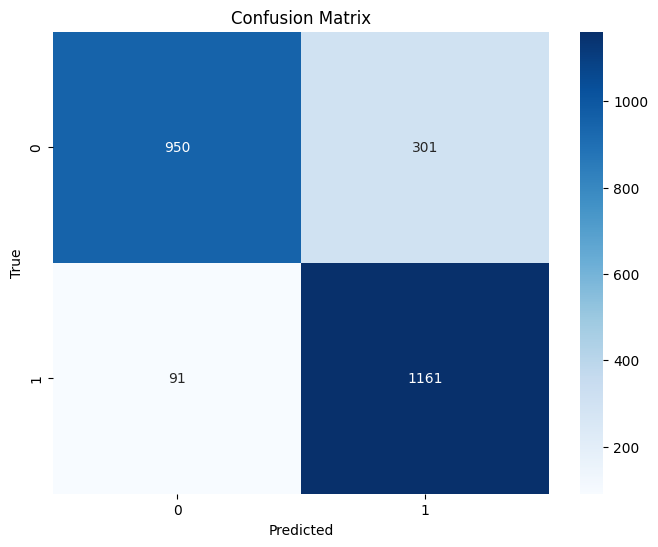

In [55]:
results = train_and_evaluate(X_train, y_train, X_val, y_val)

In [56]:
model = results['model']

In [57]:
accuracy_train = results['accuracy']
f1_score_train = results['f1_score']

print(f"Accuracy: {accuracy_train}")
print(f"F1 Score: {f1_score_train}")

Accuracy: 0.8433879344786257
F1 Score: 0.8422723498776664


In [58]:
feature_names = model.named_steps['tfidf'].get_feature_names_out()
feature_importances = model.named_steps['clf'].feature_importances_

# Obtener las características más importantes
sorted_indices = feature_importances.argsort()[::-1]

for i in sorted_indices[:20]:  # Podemos cambiar el 20 por el número de top características que queramos mostrar
    print(f"{feature_names[i]}: {feature_importances[i]}")

fuck: 0.030527687067347133
hate: 0.020344876158908707
suck: 0.019910047114462495
as: 0.018008569246837268
gay: 0.01533192821516887
damn: 0.01390104245456732
bitch: 0.01355054260601354
fucking: 0.01201884235853295
like: 0.005990872421746534
whore: 0.005620312662665495
yes: 0.005533832519896694
nerd: 0.00535519284399482
lol: 0.0052313970486483514
ever: 0.005151304492802311
im: 0.005028655780321828
love: 0.004772801770507676
emo: 0.004709879528707619
haha: 0.004213459165272302
get: 0.0041832006711904
dont: 0.004165332488486154


In [37]:
!python training.py

[2024-04-07 20:38:33 +0000] [25752] [INFO] Starting gunicorn 21.2.0
[2024-04-07 20:38:33 +0000] [25752] [INFO] Listening at: http://127.0.0.1:5000 (25752)
[2024-04-07 20:38:33 +0000] [25752] [INFO] Using worker: sync
[2024-04-07 20:38:33 +0000] [25757] [INFO] Booting worker with pid: 25757
[2024-04-07 20:38:33 +0000] [25758] [INFO] Booting worker with pid: 25758
[2024-04-07 20:38:33 +0000] [25759] [INFO] Booting worker with pid: 25759
[2024-04-07 20:38:33 +0000] [25760] [INFO] Booting worker with pid: 25760
Running for n_estimators = 2
Traceback (most recent call last):
  File "/content/training.py", line 59, in <module>
    train_and_log_model(data_path, n_stimators_list)
  File "/content/training.py", line 46, in train_and_log_model
    model.fit(x_train_vec, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit